In [58]:
import typing as tp

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from sklearn.datasets import load_boston
from IPython.display import clear_output
import pandas as pd

In [59]:
import torch.nn as nn

In [60]:
import typing as tp

## Генерация текстов -- начало

Презентация про RNN доступна по ссылке: https://docs.google.com/presentation/d/1tEvg1ozFFX_YzVBhCTR18fhmdsX51W4QgTaGzWRvkEE/edit?usp=sharing

Существуют блоки, созданные специально для обработки последовательностей, какой является текст. Можно сказать, что текст -- это последовательность символов, слов, подслов и так далее. Части, из которых состоит текст, называются *токенами*. А первым этапом при решении любой NLP задачи является токенизация.
Как правило, разным токенам сопоставляются их id -- числа.

**Задание 1** Дан файл Names.txt -- содержащий 55 тысяч индийских имён. Научимся же генерировать на их основе новые!

1) Прочитайте этот файлик и положите имена в список `all_names`
2) Сделайте из него три списка имён -- train, val и test -- разбейте файл в соотношении 0.8, 0.1, и 0.1 соответственно. Для этого подходит функция `train_test_split`из `sklearn`

**Задание 2** Посчитайте два словарика -- `id2label` и `label2id`. Первый отображает айди токена (в данном случае токен = символ) в токен(символ). Второй словарик же просто обратен первому. Важно, что оба словаря должны быть построены на основе train, причём помимо символов оттуда должны содержаться следующие:
 - '$' -- этот символ будет обозначать начало последовательности, его id должен быть равен 2
 - '^' -- этот -- конец последовательности, его id должен быть равен 1
 - '_' -- этот -- отступ, позже будет объяснено зачем, его id должен быть равен 0

In [7]:
import numpy as np

all_names = pd.read_csv('train_supervised_dataset.csv').fillna('')[['name', 'good', 'brand']].values.tolist()[:2000]
all_names = [x[0] + ' <GD> '+ x[1] + ' <BR> ' + x[2] for x in all_names]
test_names = pd.read_csv('test_dataset.csv').fillna('')['name'].values.tolist()
add_names = pd.read_csv('train_unsupervised_dataset.csv').fillna('')['name'].values.tolist()

symb = ''.join(all_names)
test_symb = ''.join(test_names)
add_symb = ''.join(add_names)
un_symb = list(set([x for x in symb+test_symb+add_symb]))

id2label = {
    0:'<pad>',
    1:'<eos>',
    2:'<sos>',
    3:'<BR>',
    4:'<GD>'
}

label2id = {
    '<pad>':0,
    '<eos>':1,
    '<sos>':2,
    '<BR>':3,
    '<GD>':4
}

ln = len(id2label)

for x in range(len(un_symb)):
    id2label[x+ln] = un_symb[x]
    label2id[un_symb[x]] = x+ln


In [10]:
del add_names, test_names

In [8]:
# assert len(id2label) == len(label2id)
# assert '_' in label2id
# assert '$' in label2id
# assert '^' in label2id
# assert label2id['_'] == 0
# assert label2id['$'] == 2
# assert label2id['^'] == 1
# for i in id2label:
#     assert i == label2id[id2label[i]]


In [61]:
from random import shuffle
import pandas as pd


all_names = pd.read_csv('train_supervised_dataset.csv').fillna('')[['name', 'good', 'brand']].values.tolist()[:2000]
all_names = [x[0] + ' <GD> '+ x[1] + ' <BR> ' + x[2] for x in all_names]
    
ln = len(all_names)

shuffle(all_names)

train = all_names[:int(ln*0.8)]
val = all_names[int(ln*0.8):int(ln*0.9)]
test = all_names[int(ln*0.9):]

In [12]:
from random import shuffle
import pandas as pd


all_names = pd.read_csv('train_unsupervised_dataset.csv')['name'].values.tolist()[:100000]
    
ln = len(all_names)

shuffle(all_names)

train = all_names[:int(ln*0.8)]
val = all_names[int(ln*0.8):int(ln*0.9)]
test = all_names[int(ln*0.9):]

In [13]:
del all_names

**Задание 3** Реализуйте функцию tokenize

In [14]:
def tokenize(name: str, add_sp_tokens = True) -> tp.List[int]:
    """принимает на вход имя, возвращает список из айдишников токенов. Так же добавляет токен начала последовательности в начало
    и токен конца последовательности в конец
    """
    
    gd = name.rsplit('<GD>', 1)
    if len(gd) == 2:
        return [2] + tokenize(gd[0], False) + [4] + tokenize(gd[1], False) + [1]
    
    br = name.rsplit('<BR>', 1)
    if len(br) == 2:
        return tokenize(br[0], False) + [3] + tokenize(br[1], False)
    
    id_list = []
    if add_sp_tokens:
        id_list = [2]
        
    for letter in name:
        id_list.append(label2id[letter])
        
    if add_sp_tokens:
        id_list.append(1)
    return id_list

In [15]:
def detokenize(list_: tp.List[int]):
    return ''.join([id2label[x] for x in list_])
        

In [37]:
def collate(names: tp.List[str]) -> torch.Tensor:
    """принимает на вход батч имён. Токенизирует их, и получившиеся списки токенов
    объединяет в тензор, предварительно дополнив каждый из них нулями (индексом токена _) при необходимости

    Для этого и пригодился токен _ -- чтобы можно было передавать последовательности разной длины в нейросеть
    для параллельной обработки

    возвращаемый тензор должен иметь размерность [максимальная длина, размер батча (len(names))]
    """
    tokenized_batch = []
    for name in names:
        tokenized_name = tokenize(name)
        tokenized_batch.append(tokenized_name)
    max_len = max([len(x) for x in tokenized_batch])
    
    for idx, array in enumerate(tokenized_batch):
        if len(array) != max_len:
            tokenized_batch[idx] = array + [0]*(max_len-len(array))
    
    torch_tensor = torch.tensor(tokenized_batch).long()
    
    return torch.swapaxes(torch_tensor, 0, 1)
    

In [39]:
class RNNNameGenerator(nn.Module):
    def __init__(
        self,
        number_of_unique_tokens: int,
        hidden_size: int, 
        embedding_size: int,
    ) -> None:
        super().__init__()
        self.embeddings = nn.Embedding(
            number_of_unique_tokens,
            embedding_size
        )
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size)
        self.classifier = nn.Linear(hidden_size, number_of_unique_tokens)

    def forward(self, prefix_token_ids: torch.Tensor) -> torch.Tensor:
        """Генерирует предсказания следующих токенов для prefix_token_ids

        :param prefix_input_ids: тензор размера (максимальная длина в батче - 1, размер батча)
        :type prefix_input_ids: torch.Tensor
        :return: тензор размера (максимальная длина в батче - 1, размер батча, количество уникальных токенов)
            важно, что должны возвращаться логиты, то есть то, что ДО softmax
        :rtype: torch.Tensor
        """
        hidden_states, last_state = self.rnn(self.embeddings(prefix_token_ids))
        logits = self.classifier(hidden_states)
        return logits


### Задание 5
Напишите лосс функцию

In [42]:
def calculate_loss_function(
    logits: torch.Tensor,
    true_labels: torch.Tensor
) -> torch.Tensor:
    """
    Считает кроссэнтропию, но усредненную только по позициям, где не символ '_'
    (считаем, что учить предсказывать этот символ бессмысленно)
    hint: используйте F.cross_entropy_loss c reduction='none', усредните лосс самостоятельно
    :param logits: of shape[max_len - 1, batch_size, num_unique_tokens]
    :type logits: torch.Tensor
    :param true_labels: of shape[max_len - 1, batch_size]
    :type true_labels: torch.Tensor
    """
    #true_labels [max_seq_len, bs]
    mask = true_labels == 0
    
    loss = F.cross_entropy(logits.permute(1, 2, 0), true_labels.T, reduction='none').T # [max_seq_len, bs]
    
    loss[mask] = 0
    
    mean = torch.mean(loss[~mask])
    
    return mean

Объявим вспомогательные классы для работы с даннными:

In [45]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, words: tp.List[str]):
        self.words = words

    def __len__(self): 
        return len(self.words)

    def __getitem__(self, idx):
        return self.words[idx]

In [62]:
train_dataset = Dataset(train)
val_dataset = Dataset(val)
test_dataset = Dataset(test)

In [63]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=collate,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    collate_fn=collate,
    drop_last=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    collate_fn=collate,
    drop_last=True,
)

### Задание 6
Реализуйте функцию

In [48]:
def generate(model, prefix: str = ''):
    current = tokenize(prefix)[:-1]  # начинаем с токена "начало последовательности"
    while current[-1] != 1:
        out = model(torch.unsqueeze(torch.tensor(current).long(), 1)) #[max_in_seq_len, bs, num_of_char]   # получаем вероятности символов следующего токена
        probs = torch.softmax(out[-1], dim=-1)  # сэмплируем этот токен пропорционально полученным вероятностям (torch.distributions.Categorical)
        distr = torch.distributions.Categorical(probs=probs)
        next = distr.sample()
        current.append(next.item())
    
    return "".join([id2label[c] for c in current[1:-1]])


In [64]:
n_epochs = 100
hidden_size = 64
embedding_size = 64

In [55]:
model = RNNNameGenerator(
    number_of_unique_tokens=len(id2label),
    hidden_size=hidden_size,
    embedding_size=embedding_size,
)
optimizer = torch.optim.Adam(model.parameters())

In [56]:
generate(model, 'Коровка из Кореновки мороженое 90г ваниль <GD>')

'Коровка из Кореновки мороженое 90г ваниль <GD>°sытn\x1dЄ┬у°Hq?oбq<BR>HъмщЭ\x186)fЛж∙ыЕ]\x1dвm_ЫРйmh'

### Задание 7 
Всё вместе

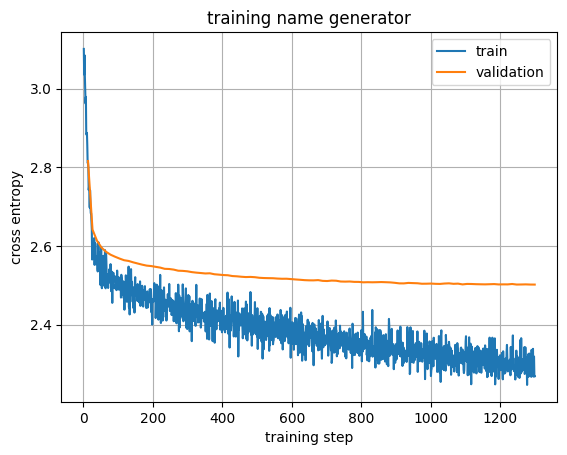

In [65]:
train_step = []
validation_step = []
train_loss_history = []
validation_loss_history = []
global_step = 0

for epoch in range(n_epochs):
    print(epoch)
    for train_batch in train_dataloader:
        # если хотим для каждого токена кроме последнего предсказать следующий, то что
        # здесь на вход модели, а что на выход? (не стесняйтесь просить хинты)
        x, y = train_batch[:-1,:], train_batch[1:,:]
        # считаем логиты
        logits = model(x)
        # считаем лосс
        loss = calculate_loss_function(logits, y)
        # backward шаг
        loss.backward()
        # шаг оптимизатора и зануление старых градиентов
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        train_step.append(global_step)
        train_loss_history.append(loss.item()) 
    
    total_val_loss = 0.0
    for val_batch in val_dataloader:
        with torch.no_grad():
            x, y = val_batch[:-1,:], val_batch[1:,:]
            logits = model(x)
            loss = calculate_loss_function(logits, y)
            total_val_loss += loss.item()
    total_val_loss /= len(val_dataloader)
    validation_step.append(global_step)
    validation_loss_history.append(total_val_loss)

    clear_output()
    plt.plot(train_step, train_loss_history, label='train')
    plt.plot(validation_step, validation_loss_history, label='validation')
    plt.xlabel('training step')
    plt.ylabel('cross entropy')
    plt.title('training name generator')
    plt.grid()
    plt.legend()
    plt.show()
        


In [102]:
total_test_loss = 0.0
for test_batch in test_dataloader:
    with torch.no_grad():
        x, y = test_batch[:-1,:], test_batch[1:,:]
        logits = model(x)
        loss = calculate_loss_function(logits, y)
        total_test_loss += loss.item()
total_test_loss /= len(test_dataloader)


assert total_test_loss < 3

In [66]:
print("Generated names")  # обученная генерация
for _ in range(20):
    print(generate(model))


Generated names
Слингкои <BR> diw LM2271990-63005, БРЬНиковый Ciriby, (02.27,53 (1318658GNiR) <GD> шоколадная гуранио д/мель <BR> atalexaag Tri Syrert Mepel Tewe LMBERANY/932 <GD> март. гурт. курпины ФИФЛАЛЬ МАМ D FFans Бир <BR> 
G KWRA <GD> мармелый мостаж (OSCONE 62-70 <GD> сигарной (73) <GD> <GD> бизкина <BR> ноское 207мм 56г <GD> алгушка <BR> 
ТЫЕ коколм 310гр <GD> шоколодени Обушя бивона 700., S 1300K90 Пак с с мми <BR> хотеменьные <GD> церлеблены "Пистрай,йофит-чирс <GD> вощеной 5756195966932-VSI 001246--619 Storck/BIILER  858л мис <BR> 
[2] УБ  гужценый №1 2*9455/26*30 шом  e*16076k2 <GD>  <GD> крешок HLВ 180-000 <GD> лобо <BR> lacw
Пирожка <BR> рукил <BR> деслое серок <BR> semty
756274 G" 160/40 <GD> вигнямия Ifschx
Прамем 3110-87116 К300088676 <GD> сером" "Breumantin 40 <GD> косные кюрг
0466 - Рокт Болко
Ябава Яглизломи <BR> palei
ЛЮЧНУ ЇTS15.6 БОARIRI Маслоко джьео) <GD> бумых 1 сметинь <BR> дримора аздинье Аз <BR> 
Кикевнячики КПР 1600 <GD> плост.Оретш "KLblyesh gal) перем П

In [67]:
def extract_entities(pred: str) -> tp.Tuple[str, str]:
    good_and_brand = pred.split('<GD>')[1]
    good_brand = good_and_brand.split('<BR>', 1)
    if len(good_brand) == 2:
        good, brand = good_brand
    else:
        good = good_brand[0]
        brand = ''
    
    brand = brand.replace('<BR>', ',')
    brand = brand.replace(' ,', ',')
    
    return good.strip(), brand.strip()
    

In [68]:
extract_entities(generate(model, 'Коровка из Кореновки <GD>'))

('крул COЦ - 6 спрафит пасаревой дайные Zurion chelumin trama', '')

In [69]:
test_frame = pd.read_csv('test_dataset.csv')

In [70]:
names = test_frame['name']
names = names.values.tolist()

In [71]:
test_frame.drop(columns=['name'], inplace=True)

In [72]:
for idx, elem in enumerate(names):
    good, brand = extract_entities(generate(model, elem + ' <GD>'))
    test_frame.loc[idx, 'good'] = good
    test_frame.loc[idx, 'brand'] = brand

In [73]:
test_frame.to_csv('submission.csv', index=False)